In [1]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedKFold
from pathlib import Path
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn


In [2]:
# Load files 
# get the staging list
path_files = '/home/b1044271/Columbia/Results/Slope_Knee_over_stages/'
path_folder = Path(path_files)

# GET FIXED MODEL FILES
search_string = 'Exp_n'
Fixed_files = []

for filename in os.listdir(path_folder):
    # check if the search string is in the filename
    if search_string in filename:
        Fixed_files.append(filename)


# GET KNEE MODEL FILES
search_string = 'Exp_w'
Knee_files = []

for filename in os.listdir(path_folder):
    # check if the search string is in the filename
    if search_string in filename:
        Knee_files.append(filename)

In [3]:
# get the staging list
path_stage = Path('/home/b1044271/EEGsleep/SleepStaging/mat/mne2/')
stage_files = os.listdir(path_stage)
stage_files = [file for file in stage_files]
stage_files = sorted(stage_files)

# get the subjects list
Data_path = '/home/b1044271/Columbia/Preprocessed/Better_ica/'
subj_files = os.listdir(Data_path)
subj_files = [file for file in subj_files]
subj_files = sorted(subj_files)

# Set up the repeated k-fold cross-validation
lin_method = RepeatedStratifiedKFold (n_splits = 5, n_repeats = 2, random_state = 1)


In [36]:
# Load and Prepare subject vectors for decoding

Slope_K_W = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_W.npy') #load files - knee 
Slope_F_W = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_W.npy') #load files - no knee
Slope_30_W = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_W.npy') #load files - no knee

Slope_K_N1 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_N1.npy') #load files - knee 
Slope_F_N1 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_N1.npy') #load files - no knee
Slope_30_N1 = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_N1.npy') #load files - no knee
  
Slope_K_N2 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_N2.npy') #load files - knee 
Slope_F_N2 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_N2.npy') #load files - no knee
Slope_30_N2 = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_N2.npy') #load files - no knee
      
Slope_K_N3 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_N3.npy') #load files - knee 
Slope_F_N3 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_N3.npy') #load files - no knee
Slope_30_N3 = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_N3.npy') #load files - no knee
  
Slope_K_R = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_R.npy') #load files - knee 
Slope_F_R = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_R.npy') #load files - no knee
Slope_30_R = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_R.npy') #load files - no knee


In [37]:
Slope_F_N1[1,183]

nan

In [38]:
# Set up the repeated k-fold cross-validation
lin_method = RepeatedKFold(n_splits=5, n_repeats=2)

accuracy_K=[]
accuracy_F=[]
accuracy_F30=[]
for i in np.arange(17):

    # Initialize the LDA classifier
    lda = LinearDiscriminantAnalysis()
    
    # DATA
    W_K = Slope_K_W[i][~np.isnan(Slope_K_W[i])]
    W_F = Slope_F_W[i][~np.isnan(Slope_F_W[i])]
    W_30= Slope_30_W[i][~np.isnan(Slope_30_W[i])]
    l1k=np.ones(len(W_K))
    l1f=np.ones(len(W_F))
    l130=np.ones(len(W_30))

    N1_K = Slope_K_N1[i][~np.isnan(Slope_K_N1[i])]
    N1_F = Slope_F_N1[i][~np.isnan(Slope_F_N1[i])]
    N1_30= Slope_30_N1[i][~np.isnan(Slope_30_N1[i])]    
    l2k=np.ones(len(N1_K))*2
    l2f=np.ones(len(N1_F))*2
    l230=np.ones(len(N1_30))*2

    N2_K = Slope_K_N2[i][~np.isnan(Slope_K_N2[i])]
    N2_F = Slope_F_N2[i][~np.isnan(Slope_F_N2[i])]
    N2_30= Slope_30_N2[i][~np.isnan(Slope_30_N2[i])]    
    l3k=np.ones(len(N2_K))*3
    l3f=np.ones(len(N2_F))*3   
    l330=np.ones(len(N2_30))*3
   

    N3_K = Slope_K_N3[i][~np.isnan(Slope_K_N3[i])]
    N3_F = Slope_F_N3[i][~np.isnan(Slope_F_N3[i])]
    N3_30= Slope_30_N3[i][~np.isnan(Slope_30_N3[i])]
    l4k=np.ones(len(N3_K))*4
    l4f=np.ones(len(N3_F))*4
    l430=np.ones(len(N3_30))*4


    R_K = Slope_K_W[i][~np.isnan(Slope_K_R[i])]
    R_F = Slope_F_W[i][~np.isnan(Slope_F_R[i])]
    R_30= Slope_30_R[i][~np.isnan(Slope_30_R[i])]
    l5k=np.ones(len(R_K))*5
    l5f=np.ones(len(R_F))*5
    l530=np.ones(len(R_30))*5

    Knee_model  = np.concatenate((W_K,N1_K,N2_K,N3_K,R_K))
    Fixed_model  = np.concatenate((W_F,N1_F,N2_F,N3_F,R_F))
    F30_model   = np.concatenate((W_30,N1_30,N2_30,N3_30,R_30))

    # remove any nans
    y1 = np.concatenate((l1k,l2k,l3k,l4k,l5k))
    y2 = np.concatenate((l1f,l2f,l3f,l4f,l5f))
    y3 = np.concatenate((l130,l230,l330,l430,l530))

    
    Z =  np.argwhere(np.isnan(Knee_model))
    Knee_model = np.delete(Knee_model,Z)
    y1 = np.delete(y1,Z)
    
    Z2 =  np.argwhere(np.isnan(Fixed_model))
    Fixed_model = np.delete(Fixed_model,Z2)
    y2 = np.delete(y2,Z2)
    
    Z3 =  np.argwhere(np.isnan(F30_model))
    F30_model = np.delete(F30_model,Z3)
    y3 = np.delete(y3,Z3)
    
    # equalize number of trials
    M = min([len(y1) , len(y2), len(y3)])
    
    Knee_model = Knee_model[0:M]
    Fixed_model = Fixed_model[0:M]
    F30_model = F30_model[0:M] 
    y1 = y1[0:M]
    y2 = y2[0:M]
    y3 = y3[0:M]

    
    # make the 1d array a 2d array (req for scikit learn)
    X=Knee_model[:, None]
    X2=Fixed_model[:, None]
    X3=F30_model[:, None]
    
    # Loop over the cross-validation folds and repetitions
    lin_score = cross_val_score(lda, X, y1, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train, X_test , y_train, y_test = train_test_split(X, y1, test_size=0.2)
    # Fit the LDA model on the training data
    lda.fit(X_train, y_train)
    # Evaluate the model on the test data
    accuracy_K.append(lda.score(X_test, y_test))
    
    # Print the accuracy for this fold
    print(f"Accuracy: {lda.score(X_test, y_test)}")
    print(X_train[1])
    # Initialize the LDA classifier
    lda2 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score2 = cross_val_score(lda2, X2, y2, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train2, X_test2 , y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)
    # Fit the LDA model on the training data
    lda2.fit(X_train2, y_train2)
    # Evaluate the model on the test data
    accuracy_F.append(lda2.score(X_test2, y_test2))
    
    # Print the accuracy for this fold
    print(f"Accuracy: {lda2.score(X_test2, y_test2)}")
    
    # Initialize the LDA classifier
    lda3 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score3 = cross_val_score(lda3, X3, y3, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train3, X_test3 , y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2)
    # Fit the LDA model on the training data
    lda3.fit(X_train3, y_train3)
    # Evaluate the model on the test data
    accuracy_F30.append(lda3.score(X_test3, y_test3))
    

Accuracy: 0.366120218579235
[1.74606466]
Accuracy: 0.5081967213114754
Accuracy: 0.3825136612021858
[2.72906113]
Accuracy: 0.4262295081967213
Accuracy: 0.41530054644808745
[1.93500213]
Accuracy: 0.34972677595628415
Accuracy: 0.4262295081967213
[0.88082629]
Accuracy: 0.5355191256830601
Accuracy: 0.39344262295081966
[0.69926473]
Accuracy: 0.43169398907103823
Accuracy: 0.39344262295081966
[1.14592038]
Accuracy: 0.5191256830601093
Accuracy: 0.3770491803278688
[2.07307725]
Accuracy: 0.5081967213114754
Accuracy: 0.36065573770491804
[1.18251977]
Accuracy: 0.5409836065573771
Accuracy: 0.44808743169398907
[0.22529197]
Accuracy: 0.546448087431694
Accuracy: 0.3551912568306011
[2.76391383]
Accuracy: 0.3989071038251366
Accuracy: 0.44808743169398907
[1.08039433]
Accuracy: 0.6557377049180327
Accuracy: 0.33879781420765026
[1.95549043]
Accuracy: 0.3333333333333333
Accuracy: 0.36065573770491804
[1.77261568]
Accuracy: 0.3989071038251366
Accuracy: 0.4207650273224044
[0.45688002]
Accuracy: 0.513661202185792

/tmp/ipykernel_3784111/246590159.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(titles)


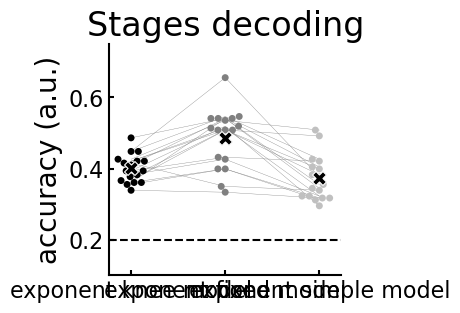

In [46]:
array_list = [accuracy_K, accuracy_F, accuracy_F30]


titles =  ['exponent knee model','exponent fixed model','exponent simple model']
colors = ['black', 'grey', 'silver']


ax = plt.figure(figsize=(3,3))  

ax = seaborn.swarmplot(data=array_list, palette = colors);
ax.set_xticklabels(titles)

seaborn.scatterplot(x=[0,1,2], y=np.mean(array_list,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list[0], array_list[1], array_list[2]], color = 'grey', linewidth = 0.25, linestyle = '-');
ax.axhline(y=0.2, color='black', linestyle='--');

plt.title('Stages decoding', fontsize = 24)
plt.ylabel('accuracy (a.u.)',fontsize=20)

plt.ylim(0.1, 0.75)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)


plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_decoding.svg", dpi = 600)



In [182]:
from scipy.stats import wilcoxon
statistic, p_value = wilcoxon(accuracy_F, accuracy_K)
p_value

7.62939453125e-05

In [180]:
from scipy.stats import friedmanchisquare

# Perform Friedman test
statistic= friedmanchisquare(accuracy_F30, accuracy_K, accuracy_F)

p_value

0.0007053515781661099

In [197]:
import scikit_posthocs as sp

data = np.array([accuracy_K,accuracy_F,accuracy_F30])

sp.posthoc_nemenyi_friedman(data.T)

,0,1,2
0,1.000000,0.001000,0.053723
1,0.001000,1.000000,0.271038
2,0.053723,0.271038,1.000000


In [185]:
np.mean(accuracy_K)

0.37737062037929925